In [10]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from itertools import cycle
import re

plt.rc("ytick.major", size=5, width=1)
plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 22
plt.rcParams["axes.labelsize"] = 22

In [11]:
#N,Blocks,Threads,Single-pass,Multi-pass
df = pd.read_csv("threadFenceReduction.csv")

#average runs with identical parameters N,Blocks,Threads
df = df.groupby(["N", "Blocks", "Threads"]).mean().reset_index()

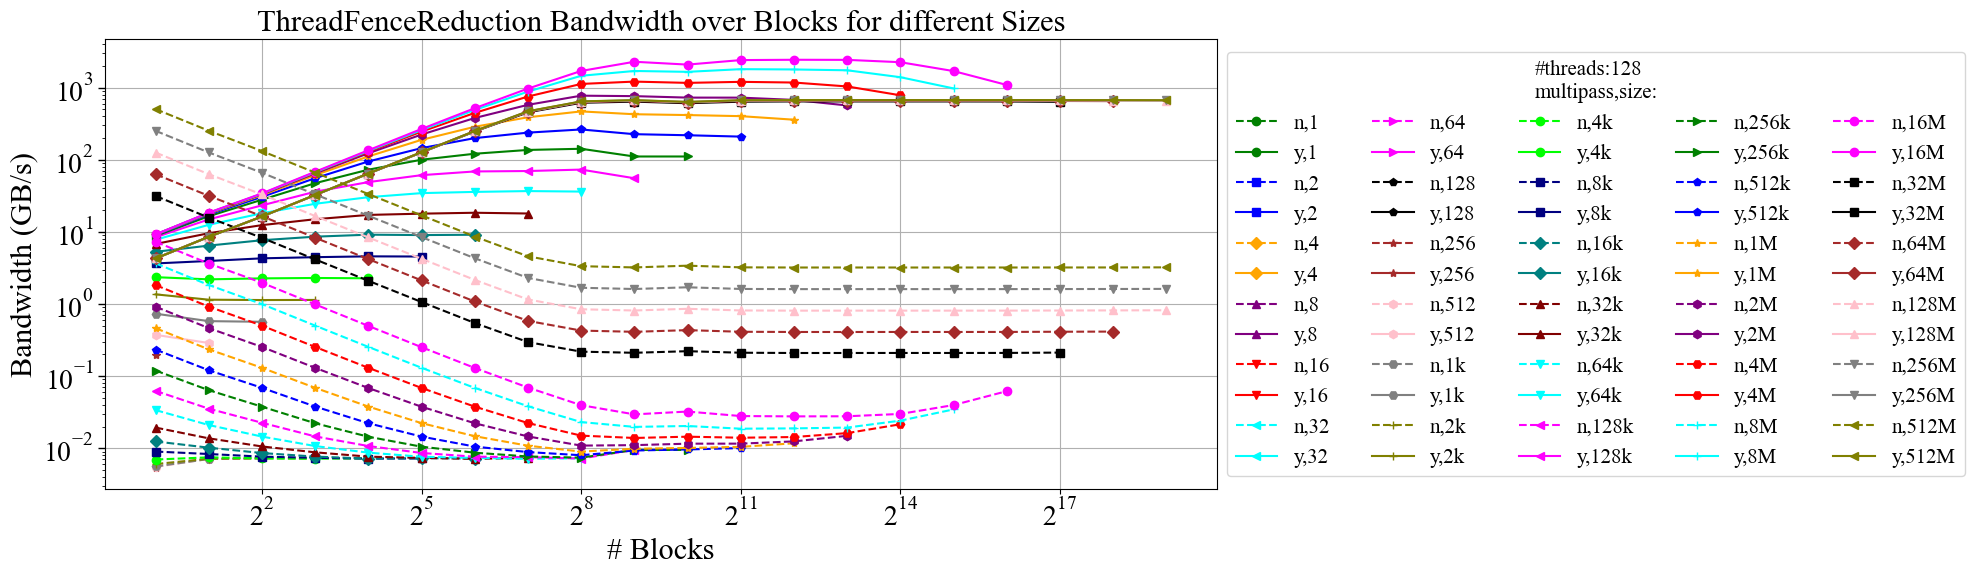

In [12]:
# Define colors and markers
colors = ['green', 'blue', 'orange', 'purple', 'red', 'cyan', 'magenta', 'black', 'brown', 'pink', 'gray', 'olive', 'lime', 'navy', 'teal', 'maroon', 'aqua', 'fuchsia']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+']
linestyles = ['-', '--', '-.', ':']
# Create cycles for colors and markers
color_cycle = cycle(colors)
marker_cycle = cycle(markers)
linestyle_cycle = cycle(linestyles)

plt.figure(figsize=(20, 6))

# filter df by blocks size and threads
for size in df["N"].unique():
    marker = next(marker_cycle)
    linestyle = next(linestyle_cycle)
    if size < 1024:
        l= str(size)
    elif size < 1024**2:
        l= f"{size // 1024}k"
    elif size < 1024**3:
        l= f"{size // 1024**2}M"
    else:
        l= f"{size // 1024**3}G"
    dff = df[(df["N"] == size) & (df["Threads"] == 128)]    
    color = next(color_cycle)
    linestyle = '--'
    plt.plot(dff["Blocks"],dff["SingleGB/s"], label=f"n,{l}", color=color, marker=marker, linestyle=linestyle)
    linestyle = '-'
    plt.plot(dff["Blocks"],dff["MultiGB/s"], label=f"y,{l}", color=color, marker=marker, linestyle=linestyle)

plt.xscale("log", base=2)
plt.yscale("log")
# plt.ylim(1e-4)
# plt.xlim(2**(0),2**29)
plt.xlabel("# Blocks")
plt.ylabel("Bandwidth (GB/s)")
plt.title("ThreadFenceReduction Bandwidth over Blocks for different Sizes")
plt.legend(title="#threads:128\nmultipass,size:", ncols=5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(which="major")
plt.tight_layout()
plt.savefig("threadFenceReduction_absolute.pdf", bbox_inches="tight")
plt.show()

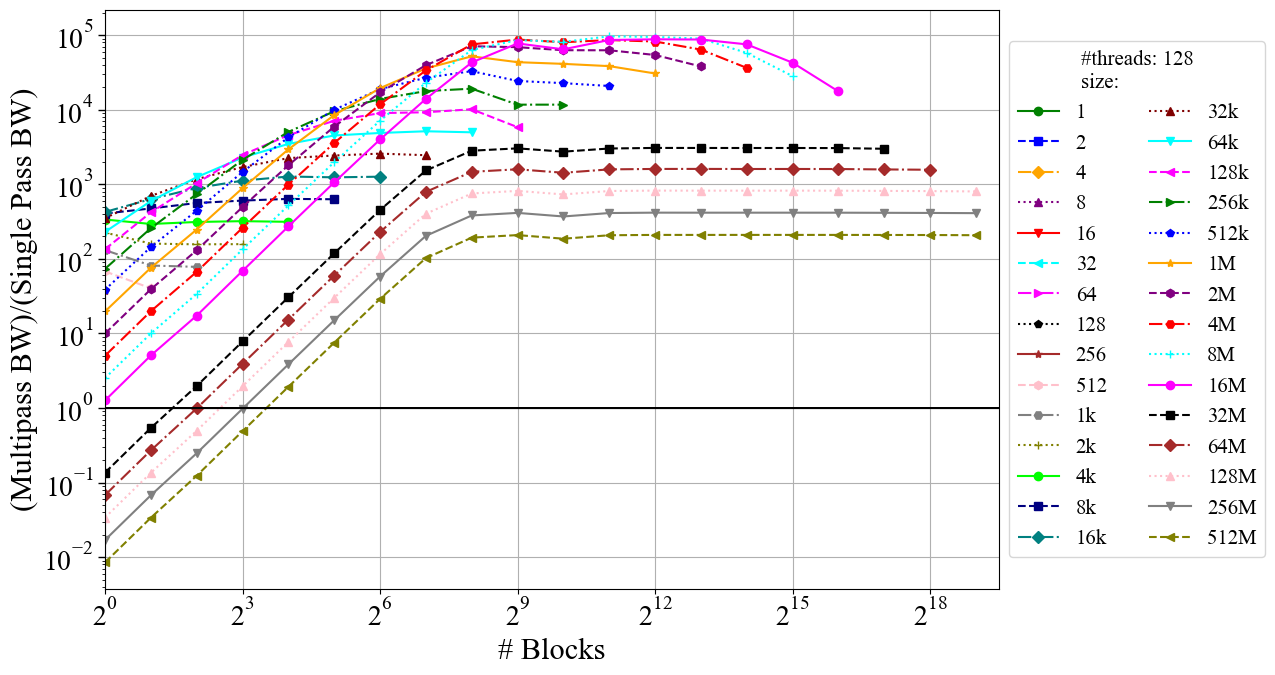

In [21]:
# Define colors and markers
colors = ['green', 'blue', 'orange', 'purple', 'red', 'cyan', 'magenta', 'black', 'brown', 'pink', 'gray', 'olive', 'lime', 'navy', 'teal', 'maroon', 'aqua', 'fuchsia']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+']
linestyle = ['-', '--', '-.', ':']

# Create cycles for colors and markers
color_cycle = cycle(colors)
marker_cycle = cycle(markers)
linestyle_cycle = cycle(linestyle)

plt.figure(figsize=(13, 7))

# filter df by blocks size and threads
for size in df["N"].unique():
    # for threads in df["Threads"].unique():
    dff = df[(df["N"] == size) & (df["Threads"] == 128)]     
    diff = dff["MultiGB/s"]/dff["SingleGB/s"]
    color = next(color_cycle)
    marker = next(marker_cycle)
    linestyle = next(linestyle_cycle)
    if size < 1024:
        l= str(size)
    elif size < 1024**2:
        l= f"{size // 1024}k"
    elif size < 1024**3:
        l= f"{size // 1024**2}M"
    else:
        l= f"{size // 1024**3}G"
    plt.plot(dff["Blocks"],diff, label=l, color=color, marker=marker, linestyle=linestyle)

plt.plot(range(0,2**20),[1 for i in range(0,2**20)],color="black",linestyle="-")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlim(1,2**19.5)
plt.xlabel("# Blocks")
plt.ylabel("(Multipass BW)/(Single Pass BW)")
# plt.title("ThreadFenceReduction Performance Comparison Single Pass vs. Multipass over\nBlocks of Different Sizes, with a Maximum Performance Difference > 5%", loc="left")
plt.legend(title="#threads: 128\nsize:", ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(which="major")
plt.tight_layout()
plt.savefig("threadFenceReduction_relative.pdf", bbox_inches="tight")
plt.show()

In [14]:
# get best performing # blocks for each size


# Define colors and markers
colors = ['green', 'blue', 'orange', 'purple', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'gray', 'olive', 'lime', 'navy', 'teal', 'maroon', 'aqua', 'fuchsia']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+']

# Create cycles for colors and markers
color_cycle = cycle(colors)
marker_cycle = cycle(markers)

# filter df by blocks size and threads
best_blocks = []

for size in df["N"].unique():
    dff = df[(df["N"] == size)]
    best_block_single = dff.loc[dff["SingleGB/s"].idxmax()]
    best_block_multi = dff.loc[dff["MultiGB/s"].idxmax()]
    if best_block_single.max() > best_block_multi.max(): best_blocks.append(best_block_single)
    else: best_blocks.append(best_block_multi)

#remove data
# Create a DataFrame with the best performing blocks
best_blocks_df = pd.DataFrame(best_blocks)
table = best_blocks_df.to_latex(index=False)

with open("table.tex", "w") as f:
    f.write(table)